### CLICLICLIMATO ###

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import random 

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import handler
from tempest import joint_distrib

from tempest.plots.hist import simple_hist
settings_path = 'settings/sam3d.yaml'

In [3]:
# Instantiate CaseStudy by passing the settings. 
# Should also create appropriate directories
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

Data loaded from /homedata/mcarenso/shear/SAM3d_Tropics/var_id_days_i_t.json
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 2.87 seconds


In [4]:
duration_min = 10
surfmaxkm2_min = 25000
save_storms_path = st.settings["DIR_DATA_OUT"]+f"save_storms_dmin{duration_min}_smin{surfmaxkm2_min}.nc"
if False : 
    storms = xr.open_dataset(st.file_storms)
    storms = storms.where(storms.INT_duration > 10, drop = True) # 1min
    storms = storms.where(storms.INT_surfmaxkm2_241K> 25000, drop = True)
    storms.to_netcdf(save_storms_path)
    storms.close
else : 
    storms = xr.open_dataset(save_storms_path)

## FileTracking is ft
ft = storms[[ 
    "INT_UTC_timeInit", "INT_UTC_timeEnd", "INT_duration", "INT_surfcumkm2_241K", "INT_velocityAvg", "INT_surfmaxkm2_241K", ## General characteristics
    "LC_lon", "LC_lat", "LC_UTC_time", "LC_ecc_241K", "LC_orientation_241K", "LC_surfkm2_241K", "LC_tb_90th", "LC_velocity" ## General characteristics
             ]]

test = xr.open_dataset("/bdd/DYAMOND/SAM-4km/OUT_3D/DYAMOND_9216x4608x74_7.5s_4km_4608_0000001440_PP.nc")
targets = [300, 2000, 4000, 8000, 12000]
z_indices = [np.abs(test.z.values - target).argmin() for target in targets]
print(z_indices)
test.close()
# z_indices  = [6, 22, 29, 37, 45]

[6, 22, 29, 37, 45]


In [10]:
test.p.values[z_indices]


array([975.308, 804.78 , 622.449, 367.137, 203.111], dtype=float32)

In [4]:
# choose an iDCS that has 3D times
ft_3d = ft.sel(time=ft.time[(ft.time - st.i_t_start + cs.settings["TIME_RANGE"][0]) % 6 == 0]) # Valid times for 3d var are %6==0 
iDCS = random.choice(ft_3d.DCS_number.values)

def get_frame_data(st, ft, iDCS):
    """
    returns everything to compute the frame and fields of a DCS over it's lifetime
    start and end corresponds to filetracking time index
    time_array corresponds to i_t of global variables (seg_mask, precip, U,...)
    """

    storm = ft.sel(DCS_number = iDCS)
    start = np.max([0,int(storm.INT_UTC_timeInit.values/st.settings["NATIVE_TIMESTEP"])-st.i_t_start])
    end = 1+int(storm.INT_UTC_timeEnd.values/st.settings["NATIVE_TIMESTEP"])-st.i_t_start
    lon_array, lat_array = storm.LC_lon[start:end].values, storm.LC_lat[start:end].values
    speed_array, time_array = storm.LC_velocity[start:end].values, storm.LC_UTC_time[start:end].values/1800 - st.i_t_start

    assert time_array[0]==start
    assert time_array[-1] +1 ==end

    time_array = time_array +st.settings["TIME_RANGE"][0]

    time_smax = -1

    if np.any(storm["LC_surfkm2_241K"] == storm["INT_surfmaxkm2_241K"]):
        time_smax = storm.LC_UTC_time[storm["LC_surfkm2_241K"] == storm["INT_surfmaxkm2_241K"]][0]
        time_smax = int(time_smax.values/1800 - st.i_t_start)
    
    return start, end, lon_array, lat_array, speed_array, time_array, time_smax


def get_valid_3d(cs):
    valid_3d = []
    for key in cs.days_i_t_per_var_id["U"].keys():
        for vt in cs.days_i_t_per_var_id["U"][key]:
            valid_3d.append(vt)
    return valid_3d

valid_3d = get_valid_3d(cs)


def get_frame_data_3d(st, ft, iDCS):
    """
    returns everything to compute the frame and fields of a DCS over it's lifetime
    start and end corresponds to filetracking time index
    time_array corresponds to i_t of global variables (seg_mask, precip, U,...)
    """

    storm = ft.sel(DCS_number = iDCS)
    start = np.max([0,int(storm.INT_UTC_timeInit.values/st.settings["NATIVE_TIMESTEP"])-st.i_t_start])
    end = 1+int(storm.INT_UTC_timeEnd.values/st.settings["NATIVE_TIMESTEP"])-st.i_t_start
    lon_array, lat_array = storm.LC_lon[start:end].values, storm.LC_lat[start:end].values
    speed_array, time_array = storm.LC_velocity[start:end].values, storm.LC_UTC_time[start:end].values/1800 - st.i_t_start

    # Initialize speed arrays with zeros
    speed_lon = np.zeros_like(lon_array)
    speed_lat = np.zeros_like(lat_array)
    for i in range(1, len(lon_array) - 1):
        speed_lon[i] = (lon_array[i + 1] - lon_array[i - 1]) / 2 #*delta_t
        speed_lat[i] = (lat_array[i + 1] - lat_array[i - 1]) / 2

    assert time_array[0]==start
    assert time_array[-1] +1 ==end

    time_array = time_array +st.settings["TIME_RANGE"][0]
    mask = np.isin(time_array, list(valid_3d))

    return start, end, lon_array[mask], lat_array[mask], speed_array[mask], time_array[mask], speed_lon[mask], speed_lat[mask]


def get_extent_slices(lons, lats, large_scale_frame_size=4):
    lon_min, lon_max = np.min(lons)-large_scale_frame_size, np.max(lons)+large_scale_frame_size
    lat_min, lat_max = np.min(lats)-large_scale_frame_size, np.max(lats)+large_scale_frame_size
    extent = [lon_min, lon_max, lat_min, lat_max]
    slice_lon = slice(lon_min, lon_max)
    slice_lat = slice(lat_min, lat_max)
    return extent, slice_lon, slice_lat


start, end, lons, lats, speeds, times, time_smax = get_frame_data(st, ft, iDCS)
start, end, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d = get_frame_data_3d(st, ft, iDCS)
extent, slice_lon, slice_lat = get_extent_slices(lons_3d, lats_3d)

print("times :" , times_3d)
print("extent :", extent)

print(start, time_smax, end)

times : [1566. 1572. 1578. 1584. 1590. 1596.]
extent : [90.62, 99.34, 17.62, 27.81]
554 571 591


In [5]:
times_3d_conv = [time for time in times_3d if time < time_smax + st.settings["TIME_RANGE"][0]]
t = len(times_3d_conv)

le_dico_long = {"latitude" : slice_lat, "longitude" : slice_lon}
le_dico_court = {    "lat" : slice_lat,       "lon" : slice_lon}

for i in range(t):
    i_t = times_3d[i]

    ### U & V Hodograph ###
    list_u = [hdlr.load_var(cs, "U", i_t, z_idx = z, sel_dict = le_dico_court) for z in z_indices]
    list_v = [hdlr.load_var(cs, "V", i_t, z_idx = z, sel_dict = le_dico_court) for z in z_indices]
    hodo_colors = ["blue", "orange", "green", "red", "purple"]
    for u, v, La_Couleur_De_L_hodographe  in zip(list_u, list_v, hodo_colors):
        ## So what do we plot haha it depends on a radius ? square ? cloud_mask ? 
        u_clean, v_clean = u.U[0,0].values, v.V[0,0].values
        u_mean, v_mean = np.mean(u_clean), np.mean(v_clean)
        # print(f"{La_Couleur_De_L_hodographe} wind norm", np.sqrt(u_mean**2 + v_mean**2))
        # ax.quiver(lons_3d[i], lats_3d[i], u_mean, v_mean, color=La_Couleur_De_L_hodographe, scale = 500/np.sqrt(u_mean**2 + v_mean**2)) #, angles='xy', scale_units='xy'

    # plot prec (threshold, percentile based?)
    prec = hdlr.load_var(cs, "Prec", i_t, sel_dict = le_dico_court).sel(le_dico_court).values
    prec_masked = np.ma.masked_less_equal(prec, 3)
    # ax.imshow(prec_masked, origin = 'lower', cmap = prec_cmap, interpolation='nearest', alpha = 1, extent = extent)


    # plot central cloud with contour TODO a func
    seg = hdlr.load_seg(i_t, sel_dict = le_dico_long)[0].values #.sel(le_dico_long)
    nan_mask = np.isnan(seg)
    output = np.full_like(seg, 0.5, dtype = float)
    output[nan_mask] = 0
    output[seg == iDCS] = 1
    # contour = ax.contour(output, levels=[0.75], colors='red', linewidths=0.5, linestyles='solid', extent = extent, transform=ccrs.PlateCarree())
    output[seg == iDCS] = 0.5
    # ax.imshow(output, origin = 'lower', cmap=cmap, interpolation='nearest', alpha = 1, norm=mcolors.Normalize(vmin=0, vmax=1), extent = extent)

    age_to_smax = int(100*np.round((i_t - st.settings["TIME_RANGE"][0] - start) / (time_smax - start), 2))
    title = f"{iDCS}, age : {age_to_smax}%"+"\n"+f'{hdlr.i_t_to_nice_datetime(i_t)}'

KeyboardInterrupt: 

In [6]:
all_times_3d = []
for key in cs.days_i_t_per_var_id["U"].keys():
    all_times_3d.extend(cs.days_i_t_per_var_id["U"][key])
print(all_times_3d)

[1008, 1014, 1020, 1026, 1032, 1038, 1044, 1050, 1056, 1062, 1068, 1074, 1080, 1086, 1092, 1098, 1104, 1110, 1116, 1122, 1128, 1134, 1140, 1146, 1152, 1158, 1164, 1170, 1176, 1182, 1188, 1194, 1200, 1206, 1212, 1218, 1224, 1230, 1236, 1242, 1248, 1254, 1260, 1266, 1272, 1278, 1284, 1290, 1296, 1302, 1308, 1314, 1320, 1326, 1332, 1338, 1344, 1350, 1356, 1362, 1368, 1374, 1380, 1386, 1392, 1398, 1404, 1410, 1416, 1422, 1428, 1434, 1440, 1446, 1452, 1458, 1464, 1470, 1476, 1482, 1488, 1494, 1500, 1506, 1512, 1518, 1524, 1530, 1536, 1542, 1548, 1554, 1560, 1566, 1572, 1578, 1584, 1590, 1596, 1602, 1608, 1614, 1620, 1626, 1632, 1638, 1644, 1650, 1656, 1662, 1668, 1674, 1680, 1686, 1692, 1698, 1704, 1710, 1716, 1722, 1728, 1734, 1740, 1746, 1752, 1758, 1764, 1770, 1776, 1782, 1788, 1794, 1800, 1806, 1812, 1818, 1824, 1830, 1836, 1842, 1848, 1854, 1860, 1866, 1872, 1878, 1884, 1890, 1896, 1902, 1908, 1914]


In [113]:
import cartopy.crs as ccrs

lon_min, lon_max = 0, 360
lat_min, lat_max = -15, 30

c_lon = 0 #(lon_min+lon_max)/2

dict_region_long = {"longitude" : slice(lon_min, lon_max), "latitude" : slice(lat_min, lat_max)}
dict_region_short = {     "lon" : slice(lon_min, lon_max),      "lat" : slice(lat_min, lat_max)}

def wind_shear_animate(i):
    print(i)
    for z_idx, ax in zip(z_indices, axs):
        ax.clear()
        i_t = all_times_3d[i]

        new_lon = np.arange(lon_min, lon_max + 1, 2)
        new_lat = np.arange(lat_min, lat_max + 1, 2)

        ### U & V Hodograph ###
        u = hdlr.load_var(cs, "U", i_t, z_idx = z_idx, sel_dict = dict_region_short).isel({"time" : 0, "z" : 0}).interp(lon=new_lon, lat=new_lat)
        v = hdlr.load_var(cs, "V", i_t, z_idx = z_idx, sel_dict = dict_region_short).isel({"time" : 0, "z" : 0}).interp(lon=new_lon, lat=new_lat)

        Lon, Lat = np.meshgrid(new_lon, new_lat)

        hodo_colors = {6 : "blue", 22 : "orange", 29 : "green", 37 : "red", 45 : "purple"}

        u_clean, v_clean = u.U.values, v.V.values
        # u_mean, v_mean = np.mean(u_clean), np.mean(v_clean)
        q = ax.quiver(Lon, Lat, u_clean, v_clean, color=hodo_colors[z_idx], scale = 1000, 
                    headaxislength = 1, 
                    headlength = 10,
                    transform=ccrs.Mercator(central_longitude = c_lon)) #scale=2/np.sqrt(u_mean**2 + v_mean**2),
        # break 

        ax.quiverkey(q, 0.9, -0.1, 1, '1 m/s', labelpos='E')
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.Mercator(central_longitude = c_lon))  

    return ax


# fig, axs = plt.subplots(5, 1, figsize=((lon_max-lon_min), (lat_max-lat_min)), subplot_kw={'projection': ccrs.Mercator(central_longitude = c_lon)})
# Lon, Lat, list_u, list_v = wind_shear_animate(0) 

In [ ]:
import matplotlib.animation as animation
from matplotlib import rcParams
rcParams['animation.embed_limit'] = 2000  # Setting limit to 1 GB

fig, axs = plt.subplots(5, 1, figsize=((lon_max-lon_min), (lat_max-lat_min)), subplot_kw={'projection': ccrs.Mercator(central_longitude = c_lon)})
t = len(all_times_3d)

plt.close('all')

ani = animation.FuncAnimation(fig, wind_shear_animate, frames=t, blit=False)

from IPython.display import HTML
HTML(ani.to_jshtml())

0
0
1
2
3
4
5


ncks: ERROR file /bdd/DYAMOND/SAM-4km/OUT_3D/DYAMOND_9216x4608x74_7.5s_4km_4608_0000249120_V.nc not found. It does not exist on the local filesystem, nor does it match remote filename patterns (e.g., http://foo or foo.bar.edu:file).
ncks: HINT file-not-found errors usually arise from filename typos, incorrect paths, missing files, or capricious gods. Please verify spelling and location of requested file. If the file resides on a High Performance Storage System (HPSS) accessible via the 'hsi' command, then add the --hpss option and re-try command.
ncks: ERROR file /bdd/DYAMOND/SAM-4km/OUT_3D/DYAMOND_9216x4608x74_7.5s_4km_4608_0000249120_V.nc not found. It does not exist on the local filesystem, nor does it match remote filename patterns (e.g., http://foo or foo.bar.edu:file).
ncks: HINT file-not-found errors usually arise from filename typos, incorrect paths, missing files, or capricious gods. Please verify spelling and location of requested file. If the file resides on a High Performan

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134


Animation size has reached 2099872594 bytes, exceeding the limit of 2097152000.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151


In [ ]:
ani.save(f'climato_shear_tropics.mp4', writer='ffmpeg', fps=8)

## Finally show

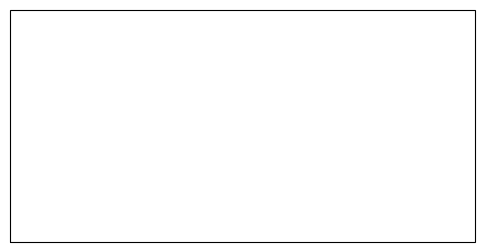

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Initialize figure and axis
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': ccrs.PlateCarree()})

colors = [(1, 1, 1, 0), (0.8, 0.8, 0.8, 0.3), (0.5, 0.5, 0.5, 1)]  # RGBA for light grey to very light grey (with transparency)
cmap = LinearSegmentedColormap.from_list("light_grey_scale", colors)
prec_cmap =  plt.get_cmap("nipy_spectral")
w_cmap = plt.get_cmap("viridis")
prec_cmap.set_bad(color=(1, 1, 1, 0))  # I think that's useless but unsure the way maps are superimposed
cmap.set_bad(color=(1, 1, 1, 0))  # Transparent for NaNs
